In [32]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u

time_conv = 977.79222167

In [14]:
sim_list = ['phantom-vacuum-grav', 'phantom-vacuum', 'phantom-Sg10-Rc4.0', 'phantom-vacuum-Sg10-Rc4.0',
            'phantom-vacuum-Sg20-Rc4.0', 'Nbody']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f


In [4]:
sn0_list = []
sn2_list = []
sn3_list = []
sn4_list = []
idx_list = [0, 50, 100, 150, 200]#, 100, 125]
for idx in tqdm(idx_list):
    sn0 = read_snap(idx, 0, parttype=None, fields=None)
    sn0_list.append(sn0)
    
    sn2 = read_snap(idx, 2, parttype=None, fields=None)
    sn2_list.append(sn2)
    
    sn3 = read_snap(idx, 3, parttype=None, fields=None)
    sn3_list.append(sn3)
    
    sn4 = read_snap(idx, 4, parttype=None, fields=None)
    sn4_list.append(sn4)



A Jupyter Widget

In [15]:
sfr0 = read_sfr(0)
sfr1 = read_sfr(1)
sfr2 = read_sfr(2)
sfr3 = read_sfr(3)
sfr4 = read_sfr(4)

fourier3 = read_fourier(3)
fourier4 = read_fourier(4)
fourierN = read_fourier(5)

In [16]:
def extract_t_A2A0(fourier, idx):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        A2r = fourier[key]['A2r'][idx]
        A2i = fourier[key]['A2i'][idx]
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
        A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_max_A2A0(fourier):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = np.array(fourier[key]['A0'])
        A2r = np.array(fourier[key]['A2r'])
        A2i = np.array(fourier[key]['A2i'])
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
#         A2A0 = A2/A0
        A2A0list.append(np.max(A2/A0))
#         A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_AmA0(fourier, idx, m):

    i = 0

    tlist = np.array(fourier['time'])
    AmA0list = []
#     print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        Amr = fourier[key]['A'+str(m)+'r'][idx]
        Ami = fourier[key]['A'+str(m)+'i'][idx]
    
        Am = np.sqrt(Amr*Amr + Ami*Ami)
        AmA0list.append(Am/A0)
        i += 1
    
    return np.array(tlist), np.array(AmA0list)

In [17]:
def my_bin(X, Xbins, Y, func=np.mean):
    Xmin = Xbins[0]
    Xmax = Xbins[-1]
    assert Xmin==np.min(Xbins), "First entry of Xbins is not the min value"
    assert Xmax==np.max(Xbins), "Last entry of Xbins is not the max value"

    keys = np.logical_and(X > Xmin, X < Xmax)

    digit = np.digitize(X[keys], Xbins)
    X_avg = [X[keys][digit == i].mean() for i in range(1, len(Xbins))]
    Y_func = [func(Y[keys][digit == i]) for i in range(1, len(Xbins))]

    return np.array(X_avg), np.array(Y_func)

def compute_sfr_profile(sn, center=[200, 200, 200],
                        Rmin=0.1, Rmax=20, nbins=20):

    #get pos of gas
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    sfr = np.copy(sn.part0.sfr.value) # Msun/yr

    #do binning
    bins = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins)
#     bins = np.linspace(Rmin, Rmax, nbins)
    R_binned, tot_sfr_binned = my_bin(R, bins, sfr, np.sum)

    # now go through and divide by area of bin
    for i in range(len(R_binned)):
        surf_area = np.pi * (bins[i+1]**2 - bins[i]**2) * (1E6) # 1E6 converts to Msun/yr/pc^2
        tot_sfr_binned[i] /= surf_area
        tot_sfr_binned[i] *= 1E9 # conerts to Msun/pc^2/Gyr

    return R_binned, tot_sfr_binned

def compute_gas_profile(sn, center=[200, 200, 200],
                        Rmin=0.1, Rmax=20, nbins=20):

    #get pos of gas
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    gas_mass = 1E10 * np.copy(sn.part0.mass.value)

    #do binning
    bins = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins)
#     bins = np.linspace(Rmin, Rmax, nbins)
    R_binned, tot_sfr_binned = my_bin(R, bins, gas_mass, np.sum)

    # now go through and divide by area of bin
    for i in range(len(R_binned)):
        surf_area = np.pi * (bins[i+1]**2 - bins[i]**2) * (1E6) # 1E6 converts to Msun/pc^2
        tot_sfr_binned[i] /= surf_area
        
    return R_binned, tot_sfr_binned

def compute_HI_profile(sn, center=[200, 200, 200],
                        Rmin=0.1, Rmax=20, nbins=20):

    #get pos of gas
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    gas_mass = 1E10 * np.copy(sn.part0.mass.value) * sn.part0.NeutralHydrogenAbundance

    #do binning
    bins = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins)
#     bins = np.linspace(Rmin, Rmax, nbins)
    R_binned, tot_sfr_binned = my_bin(R, bins, gas_mass, np.sum)

    # now go through and divide by area of bin
    for i in range(len(R_binned)):
        surf_area = np.pi * (bins[i+1]**2 - bins[i]**2) * (1E6) # 1E6 converts to Msun/pc^2
        tot_sfr_binned[i] /= surf_area
        
    return R_binned, tot_sfr_binned

def compute_HI_vol_dens(sn, center=[200, 200, 200],
                        Rsun=8.2, dR=0.1, dz=0.2):
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    z = pos[:,2]
    gas_mass = 1E10 * np.copy(sn.part0.mass.value) * sn.part0.NeutralHydrogenAbundance
    
    Rbool = np.abs(R-Rsun) < dR
    zbool = np.abs(z) < dz
    
    tot_mass = np.sum(gas_mass[np.logical_and(Rbool, zbool)])
    tot_vol = (np.pi*(Rsun+dR)**2 - np.pi*(Rsun-dR)**2) * (2. * dz) # in kpc^3
    tot_vol *= 1E9 # in pc^3
    
    return tot_mass/tot_vol

def compute_star_vol_dens(sn, center=[200, 200, 200],
                        Rsun=8.2, dR=0.1, dz=0.2):
    
    star_mass = 0
    for i in [2, 3, 4]:
        if sn.NumPart_Total[i] > 0:
            part = getattr(sn, 'part'+str(i))
            pos = np.subtract(part.pos, center)
            R = np.linalg.norm(pos[:,:2], axis=1)
            z = pos[:,2]
            try:
                mass = 1E10 * np.copy(part.mass.value)
            except:
                mass = 1E10 * np.full(sn.NumPart_Total[i], sn.MassTable[i])
    
            Rbool = np.abs(R-Rsun) < dR
            zbool = np.abs(z) < dz
    
            star_mass += np.sum(mass[np.logical_and(Rbool, zbool)])
    
    tot_vol = (np.pi*(Rsun+dR)**2 - np.pi*(Rsun-dR)**2) * (2. * dz) # in kpc^3
    tot_vol *= 1E9 # in pc^3
    
    return star_mass/tot_vol
    

In [18]:
from numba import njit
@njit
def _binned_average(x, y, bins):
    N = len(bins)
    
    sum_x_in_bin = np.zeros(N-1)
    sum_y_in_bin = np.zeros(N-1)
    N_in_bin = np.zeros(N-1)
    
    for i in range(len(x)):
        this_x = x[i]
        for j in range(N-1):
            if this_x > bins[j] and this_x < bins[j+1]:
                sum_x_in_bin[j] += x[i]
                sum_y_in_bin[j] += y[i]
                N_in_bin[j] += 1
    
    for j in range(N-1):
        sum_x_in_bin[j] /= N_in_bin[j]
        sum_y_in_bin[j] /= N_in_bin[j]
    
    return sum_x_in_bin, sum_y_in_bin
    
def binned_average(x, y, dx):
    xmin = np.min(x)
    xmax = np.max(x)

    bins = np.arange(xmin, xmax+dx, dx)
    return _binned_average(x, y, bins)

In [ ]:
sn_list = sn0_list
title = 'exp profile, vacuum'

fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax.axhline(10, c='k', ls='dashed')

for i,idx in enumerate(idx_list):
#     if idx not in [100]:#, 400, 600]:
#         continue
    
    R0, gas0 = compute_HI_profile(sn_list[i])
    time = sn_list[i].Time.value
    l = ax.plot(R0, gas0, label="{:0.0f}".format(time*time_conv))
# #     try:
# #         R1, gas1 = compute_HI_profile(sn1_list[i])
# #         ax.plot(R1, gas1, c=l[0].get_color(), ls='dashed')
# #     except:
# #         pass
    
# #     try:
# #         R2, gas2 = compute_HI_profile(sn2_list[i])
# # #         ax.plot(R2, gas2, c=l[0].get_color(), ls='dotted')
# #     except:
# #         pass

# R, gas = compute_HI_profile(sn)
# ax.plot(R, gas)

ax.set(yscale='log', ylim=(0.1, 100), xlabel='R [kpc]', ylabel='surf dens [Msun/pc^2]', title=title)
ax.legend()
plt.show()

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/n/home01/abeane/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


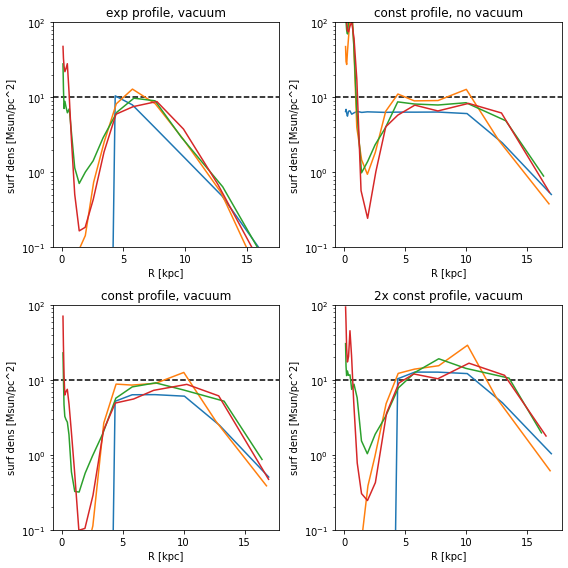

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

sn_list_list = [sn0_list, sn2_list, sn3_list, sn4_list]
title_list = ['exp profile, vacuum', 'const profile, no vacuum', 'const profile, vacuum', '2x const profile, vacuum']

for sn_list, title, this_ax in zip(sn_list_list, title_list, ax.flatten()):
    this_ax.set(yscale='log', ylim=(0.1, 100), xlabel='R [kpc]', ylabel='surf dens [Msun/pc^2]', title=title)
    this_ax.axhline(10, c='k', ls='dashed')
    
    for i, idx in enumerate(idx_list):
        try:
            R, gas = compute_HI_profile(sn_list[i])
            time = sn_list[i].Time.value
            l = this_ax.plot(R, gas, label="{:0.0f}".format(time*time_conv))
        except:
            pass

fig.tight_layout()
plt.show()
    

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/n/home01/abeane/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


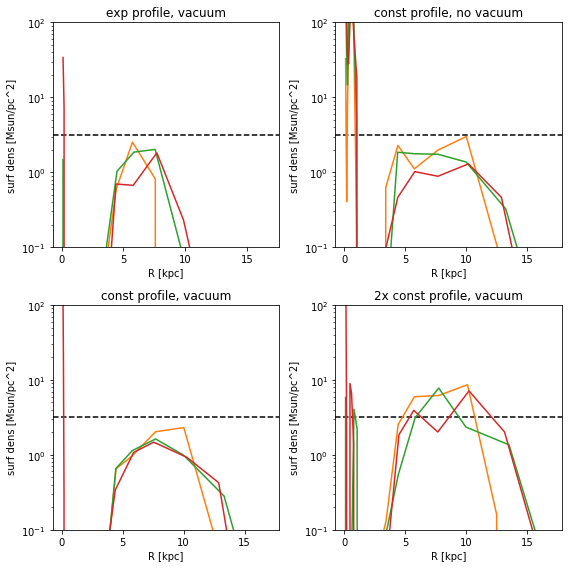

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

sn_list_list = [sn0_list, sn2_list, sn3_list, sn4_list]
title_list = ['exp profile, vacuum', 'const profile, no vacuum', 'const profile, vacuum', '2x const profile, vacuum']

for sn_list, title, this_ax in zip(sn_list_list, title_list, ax.flatten()):
    this_ax.set(yscale='log', ylim=(0.1, 100), xlabel='R [kpc]', ylabel='surf dens [Msun/pc^2]', title=title)
    this_ax.axhline(10.**(0.5), c='k', ls='dashed')
    
    for i, idx in enumerate(idx_list):
        try:
            R, gas = compute_sfr_profile(sn_list[i])
            time = sn_list[i].Time.value
            l = this_ax.plot(R, gas, label="{:0.0f}".format(time*time_conv))
        except:
            pass

fig.tight_layout()
plt.show()
    

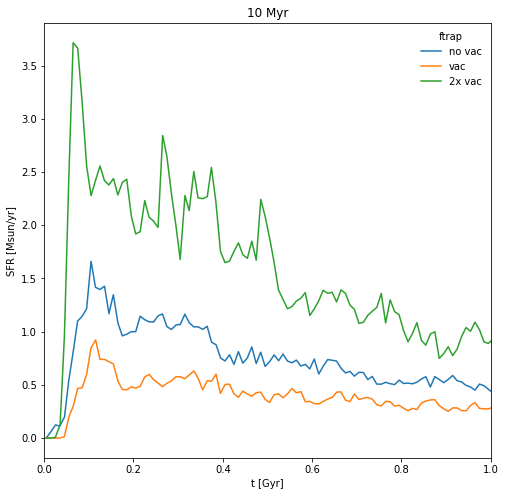

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dt = 0.01

t, SFR = binned_average(sfr2[:,0], sfr2[:,2], dt)
ax.plot(t, SFR, label='no vac')

t, SFR = binned_average(sfr3[:,0], sfr3[:,2], dt)
ax.plot(t, SFR, label='vac')

t, SFR = binned_average(sfr4[:,0], sfr4[:,2], dt)
ax.plot(t, SFR, label='2x vac')

# t, SFR = binned_average(sfr_8[:,0], sfr_8[:,2], dt)
# ax.plot(t, SFR, label='8')

ax.legend(frameon=False, title='ftrap')
ax.set(xlabel='t [Gyr]', ylabel='SFR [Msun/yr]')
ax.set_xlim(0, 1)
ax.set_title('10 Myr')
plt.show()

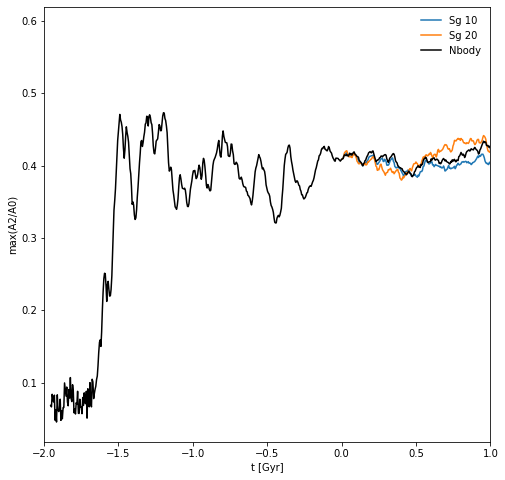

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dt = 0.01

t, A2A0 = extract_t_max_A2A0(fourier3)
ax.plot(t/1000.0, A2A0, label='Sg 10')

t, A2A0 = extract_t_max_A2A0(fourier4)
ax.plot(t/1000.0, A2A0, label='Sg 20')

start_snap = 400
t, A2A0 = extract_t_max_A2A0(fourierN)
t -= t[400]
ax.plot(t/1000.0, A2A0, label='Nbody', c='k')

# t, SFR = binned_average(sfr_8[:,0], sfr_8[:,2], dt)
# ax.plot(t, SFR, label='8')

ax.legend(frameon=False)
ax.set(xlabel='t [Gyr]', ylabel='max(A2/A0)')
ax.set_xlim(-2, 1)
plt.show()

In [22]:
t

array([   0.        ,    5.25181781,   10.02619763,   14.80057746,
         19.57495728,   24.82677509,   29.60115491,   34.37553474,
         39.14991456,   44.40173237,   49.17611219,   53.95049202,
         58.72487184,   63.97668965,   68.75106947,   73.5254493 ,
         78.29982912,   83.55164693,   88.32602675,   93.10040658,
         97.8747864 ,  103.12660421,  107.90098403,  112.67536386,
        117.44974368,  122.22412351,  127.47594131,  132.25032114,
        137.02470096,  141.79908079,  147.05089859,  151.82527842,
        156.59965824,  161.37403807,  166.62585588,  171.4002357 ,
        176.17461552,  180.94899535,  186.20081316,  190.97519298,
        195.7495728 ,  200.52395263,  205.77577044,  210.55015026,
        215.32453009,  220.09890991,  225.35072772,  230.12510754,
        234.89948737,  239.67386719,  244.44824701,  249.70006482,
        254.47444465,  259.24882447,  264.0232043 ,  269.2750221 ,
        274.04940193,  278.82378175,  283.59816158,  288.84997

## Pattern Speed

In [33]:
def get_bar_angle(phi, firstkey):
    out = np.zeros(len(phi))

    # set the first bar angle
    first_bar_angle = phi[firstkey]/2.0
    out[firstkey] = first_bar_angle
    
    # set all subsequent angles
    for i in np.arange(firstkey+1, len(out)):
        dphi = phi[i] - phi[i-1]
        if dphi < 0:
            dphi += 2.*np.pi
        out[i] = out[i-1] + dphi/2.0

    # set all previous angles to be the bar angle
    for i in np.arange(0, firstkey):
        out[i] = first_bar_angle

    return out

def get_sorted_keys(dat):
    keys = list(dat.keys())
    # only keep keys that are snapshot keys
    keys = [k for k in keys if 'snapshot' in k]

    # extract and sort indices
    indices = [int(re.findall(r'\d?\d?\d\d\d', k)[0]) for k in keys]
    sorted_arg = np.argsort(indices)
    keys_sorted = [keys[i] for i in sorted_arg]

    return keys_sorted

def get_A2_angle(dat, keys):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    phi = np.arctan2(A2i, A2r)
    phi = phi[:,Rbin]
    R_at_Rbin = Rlist[:,Rbin]
    
    time = np.array(dat['time'])

    return time, R_at_Rbin, phi

def evaluate_polynomial(pfit, n, time, bar_angle_firstkey, firstkey):
    pfit_n = pfit[n]
    poly_bar_angle = np.zeros(len(time))
    poly_pattern_speed = np.zeros(len(time))

    for i in range(n+1):
        ba = pfit_n[i] * time ** (n-i)
        poly_bar_angle[firstkey:] += ba[firstkey:]
        ps = (n-i) * pfit_n[i] * time**(n-1-i)
        poly_pattern_speed[firstkey:] += ps[firstkey:]

    poly_bar_angle[:firstkey] += bar_angle_firstkey

    poly_pattern_speed = poly_pattern_speed / u.Myr
    poly_pattern_speed = poly_pattern_speed.to_value(u.km/u.s/u.kpc)

    return poly_bar_angle, poly_pattern_speed

def master_bar_angle(dat, Rbin = 5, firstkey = 150, nmax = 10):
    # try loading snapshot
#     dat = h5.File(fname, mode='r')
    out = {}

    keys = get_sorted_keys(dat)
    time, R, phi = get_A2_angle(dat, keys)
    bar_angle = get_bar_angle(phi, firstkey)

    pattern_speed = np.gradient(bar_angle, time) / u.Myr
    pattern_speed = pattern_speed.to_value(u.km/u.s/u.kpc)

    pfit = [np.polyfit(time[firstkey:], bar_angle[firstkey:], i) for i in range(nmax)]
    
    out['time'] = time
    out['firstkey'] = firstkey
    out['R'] = R
    out['phi'] = phi
    out['bar_angle'] = bar_angle
    out['pattern_speed'] = pattern_speed
    out['pfit'] = pfit

    # now evaluate the polynomial for each fit and save the result
    out['poly_eval'] = {}
    for n in range(nmax):
        poly_bar_angle, poly_pattern_speed = evaluate_polynomial(pfit, n, time, bar_angle[firstkey], firstkey)

        out['poly_eval'][n] = (poly_bar_angle, poly_pattern_speed)

    return out

In [36]:
outN = master_bar_angle(fourierN)
out3 = master_bar_angle(fourier3)
out4 = master_bar_angle(fourier4)

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in reciprocal
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply


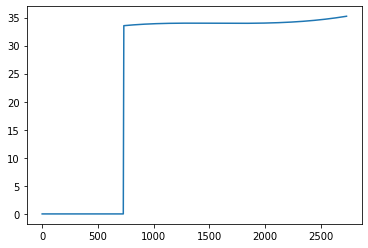

In [45]:
fig, ax = plt.subplots(1, 1)
dat = out4
n=5
name = 'Nbody'

time = dat['time']
ba, ps = dat['poly_eval'][n]
true_ps = dat['pattern_speed']
ax.plot(time-time[0], ps, label=name)
plt.show()